# IATS 2022 - Image Analysis Training School at the University of Nottingham
## Vincenzo Della Mea, MITEL, University of Udine

This [Jupyter](https://jupyter.org) notebook is aimed at introducing IATS 2022 attendants to the application of CNNs to histologic images, with an easy learning path based on [Fastai](https://www.fast.ai). It does not aim at people already expert in Python and deep learning. I suggest to take the Fastai course for Vision if you want to learn more on both the topic and on the framework.

It is in no way exhaustive, and also the image data set provided cannot be considered more than an example of what can be done. 
The image set comes from a larger digital slide repository developed during the EU MSCA [AIDPATH](http://aidpath.eu) project. However, for this exercise only some image has been used.

Before running code, please set the runtime type to use a GPU (Menu *Runtime: Runtime type: Hardware Accelerator: GPU*). In the same dialog, runtime type should be set as **Python 3**.
In this specific exercise, using CPU will still result in acceptable training times, however when the training set is larger, it quickly becomes too much. If it happens that you select after having started running the code, you have to start again.

---

The next cells include either instructions and explanations or Python code, plus sometimes shell (Unix) commands prefixed by "!". You may run them one by one, or all together from the "*Runtime*" Menu. After running a cell, the output becomes visible just behind, and is also saved.


The next cell is used to setup the Fastai environment, and to include useful libraries. Click on the "[ ]" icon on the left side to run it.

In [1]:
from fastai import *
from fastai.vision import *
from fastai.vision.all import *

import numpy as np
from google.colab import files
from zipfile import ZipFile


Now let's import the image set we will use for the exercise. We will get it from MITEL web site.
**Do not redistribute the image set: it is not validated and not meant for general public.**

In [ ]:
!wget --no-check-certificate https://mitel.dimi.uniud.it/IATS/IATS.zip
with ZipFile('IATS.zip', 'r') as zf:
    zf.extractall('data/')
!ls data

Now set some parameters used in the process. 
Regarding the model, you may find a list [here](https://docs.fast.ai/vision.models.html).
With the parameters chosen, we will do transfer learning on a a model pretrained on the [Imagenet](http://www.image-net.org) image set. This will save us time (less epochs needed).

In [20]:
path='data/IATS2020'
testpath='data/IATS2020/test/'
batch_size=32 #this can be changed because it effects results, however if too large, GPU memory will not suffice
resize=224 #current CNN model use very small images (e.g., 224x224); you can let this be as large as our images (512) but not too much
model = resnet34 #you may try with other pretrained models, e.g.,  resnet152
epochs=2 #training iterations on the image set
outfile = 'predictions.csv'


In the next cell we prepare the learner object (*classifier*), starting from the transformed and normalised image set.

In [ ]:
 #to augment the data set,  a number of transformations is usually done, e.g., flipping, rotating, slight zooming, etc
tfms = tfms = aug_transforms(min_zoom=1.0, max_zoom=1.0, max_warp=0, flip_vert=True)
images = ImageDataLoaders.from_folder(path,ds_tfms=tfms,  bs=batch_size, test='test',  item_tfms=Resize(resize))
# batch_tfms=Normalize.from_stats(*imagenet_stats)
classifier = vision_learner(images, model, metrics=accuracy)


Before starting the process, let's look at our images.

In [ ]:
images.show_batch()

## Training
Finally, we  can start **training**. Done this way, only the last layer of the network is trained. It could be sufficient or not, depending on the image set. You will see the output epoch by epoch, including accuracy on the validation set (but be careful, not always accuracy is sufficient to evaluate performance).

In [ ]:
classifier.fit_one_cycle(epochs)

In a complete process, you may want to train also the first layers of the network, typically after having trained the last as above, and for less epochs. To do so, you have to "unfreeze" the network.

In [ ]:
classifier.unfreeze()
classifier.fit_one_cycle(2)

Before classifying our test set, let's look at results.

In [ ]:
interp = ClassificationInterpretation.from_learner(classifier)
print(interp.confusion_matrix())
interp.print_classification_report()

Which images went particularly wrong?

In [ ]:
interp.plot_top_losses(9, figsize=(12,12))

Let's look at some examples:

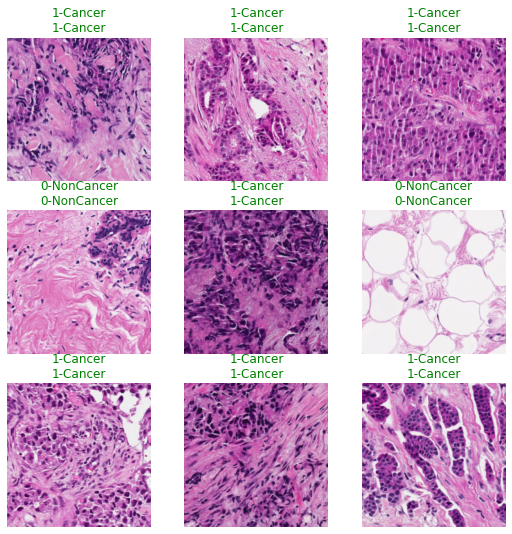

In [13]:
classifier.show_results()

## Predictions
We can finally predict the classes for the test set. There are other ways of doing this. 
The output is a CSV file with the proposed class (all those >0.6 probability), and also the probability of each class. 
If you have more than two classes, you might have more than one proposed class.

In [ ]:
classname=["NonCancer","Cancer"]
files = get_image_files(testpath)
test_dl = classifier.dls.test_dl(files, bs=batch_size,item_tfms=Resize(resize))
preds, y = classifier.get_preds(dl=test_dl)


fnames = [f.name[:-4] for f in test_dl.items]
i=0
for f in fnames:
  best=np.argmax(preds[i])
  bestclass=classname[best]
  pcancer=preds[i][1].item()
  print(f,bestclass,round(pcancer,5),sep=',')  
  i+=1	


## Some extras

The next cell let you copy images from your Google Drive, assuming you have a "mydata" folder with a zip file inside that contains the folder structure for Fastai.
You may put this instead of the second code cell.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls gdrive
# In principle, you may also directly work with the folder structure directly stored on Google Drive,
# but file access is much slower, and you will spend more time in training. Better to move on the Colab disk. 
with ZipFile('/content/gdrive/My Drive/mydata/IATS2019.zip', 'r') as zf:
    zf.extractall('data/')


You may save the trained model for further use:

In [ ]:
classifier.export()

Fastai has a method to random split a training set to obtain the validation set. 
However, the next cell shows how to do it from the shell: put all training images in the train folder, then launch the commands below. Substitute 200 with the number of images you want in each class in the validation set.

In [ ]:
!shuf -n 200 -e data/train/0-NonCancer/* | xargs -I{} mv {} data/valid/0-NonCancer/
!shuf -n 200 -e data/train/1-Cancer/* | xargs -I{} mv {} data/valid/1-Cancer/
